In [180]:
import libsumo as traci
import time
import random
import numpy as np
import csv
import os
import random, numpy as np
import pandas as pd, matplotlib.pyplot as plt

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
# Imports and configuration
# Use sumo or sumo-gui depending on your preference
SUMO_GUI_BINARY  = "sumo-gui"  # or "sumo-gui"
SUMO_BINARY  = "sumo"  # or "sumo-gui"
SUMO_CFG  = "./sumo_cfg/simulation.sumocfg"  # your .sumocfg file
SUMO_STATE = "./sumo_cfg/simulation_state.xml"  # your initial state file
LOG_DIR= "logs"

# Global timing constants
REDUCE_AVG_WAIT_TIME_W, FAIRNESS_W, LOST_TIME_W = 0.6, 0.2, 0.2  # prioritize queue clearance
CYCLE_LENGTH_DEFAULT = 90   # s
MAX_CYCLE_LENGTH = 120      # s
MIN_CYCLE_LENGTH = 80      # s
LOST_TIME = 12              # s (amber + all-red total)
GREEN_MIN = 20             # s per direction
MIN_GREEN_SPLIT = GREEN_MIN / MAX_CYCLE_LENGTH  # minimum green split ratio

In [181]:
#Intersection metadata
# Define lane groups for metric aggregation
NS_LANES = ["1200728225#1_0", "1200728225#1_1", "1221994726#0_0", "1221994726#0_1"]  # replace with your real lane IDs
EW_LANES = ["1265822568#3_0", "1265822568#3_1", "1265822568#3_2"]

# Your target traffic light ID
TL_ID = "cluster_13075564400_13075589603_411926344"  # replace with your actual traffic light id in SUMO net

In [182]:
def apply_plan(tl_id, g_main, g_cross, amber=3, all_red=3):
    """
    Define a 2-phase signal plan (NS and EW) with amber and all-red times.
    """
    amrber_red_phase_duration = amber + all_red
    phases = [
        traci.trafficlight.Phase(g_main, "rrrrrGGggGGG"),   # NS green
        traci.trafficlight.Phase(amrber_red_phase_duration, "rrrrryyyyyyy"),    # NS amber
        traci.trafficlight.Phase(g_cross, "GGGGGrrrrrrr"),  # EW green
        traci.trafficlight.Phase(amrber_red_phase_duration, "yyyyyrrrrrrr"),    # EW amber
    ]

    logic = traci.trafficlight.Logic("custom_logic", 0, 0, phases)
    traci.trafficlight.setCompleteRedYellowGreenDefinition(tl_id, logic)

    # Metrics calculation
def cycle_metrics(ns_lanes, ew_lanes, steps):
    ns_wait_total = ew_wait_total = 0
    ns_veh = ew_veh = 0

    for _ in range(steps):
        traci.simulationStep()

        # Lane-level aggregates
        ns_stopped = sum(traci.lane.getLastStepHaltingNumber(l) for l in ns_lanes)
        ew_stopped = sum(traci.lane.getLastStepHaltingNumber(l) for l in ew_lanes)

        ns_wait_total += ns_stopped
        ew_wait_total += ew_stopped

        # Count total vehicles present (not per-step repetition)
        ns_veh += sum(traci.lane.getLastStepVehicleNumber(l) for l in ns_lanes)
        ew_veh += sum(traci.lane.getLastStepVehicleNumber(l) for l in ew_lanes)

    # Compute average per-direction delay (approx.)
    avg_delay_ns = ns_wait_total / max(ns_veh, 1)
    avg_delay_ew = ew_wait_total / max(ew_veh, 1)
    # Fairness (bounded 0–1)
    fairness = abs(avg_delay_ns - avg_delay_ew) / (avg_delay_ns + avg_delay_ew + 1e-5)
    # Normalized total average delay
    norm_avg_delay = ((ns_wait_total + ew_wait_total) / max(ns_veh + ew_veh, 1))

    return norm_avg_delay, fairness

def get_green_split(s, C):
    g_main = max(GREEN_MIN, round((C - LOST_TIME) * s))
    g_cross = max(GREEN_MIN, (C - LOST_TIME) - g_main)
    return g_main, g_cross


In [183]:
# Evaluation function
def evaluate(s, C, isReset=True):
    try:    
        # Restore identical starting conditions before evaluating this candidate
        if isReset:
            traci.simulation.loadState(SUMO_STATE)
            time.sleep(0.01)
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)
        steps = int(C)
        O1_norm, O2_norm = cycle_metrics(NS_LANES, EW_LANES, steps)

    except traci.exceptions.FatalTraCIError as e:
        print("⚠️ SUMO crashed during evaluation:", e)
        return C, 1  # return a default
    return O1_norm, O2_norm

def score_function(O1, O2, O3):
    score = (REDUCE_AVG_WAIT_TIME_W * O1) + (FAIRNESS_W * O2) + (LOST_TIME_W * O3)
    return score

def evaluate_multi_cycle(x, n_cycles=3):
    """Evaluate the same (s, C) across consecutive cycles without resetting."""
    # Start from base state once
    s, C = float(x[0]), round(float(x[1]))
    traci.simulation.loadState(SUMO_STATE)
    total_O1 = total_O2 = 0
    for _ in range(n_cycles):
        O1, O2 = evaluate(s, C, isReset=False)  # continue simulation
        total_O1 += O1
        total_O2 += O2
    return total_O1 / n_cycles, total_O2 / n_cycles

# x consist of split-Cycle
def evaluate_candidate(x):
    s, C = float(x[0]), round(float(x[1]))  # round C for realism
    O1, O2 = evaluate(s, C)
    O3 = LOST_TIME / C
    return O1, O2, O3

def robust_evaluate(x, n_cycles=2, λ=0.3):
    """Returns (robust_score, mean_O1, mean_O2)"""
    scores = []
    for _ in range(n_cycles):
        O1, O2 = evaluate_multi_cycle(x, n_cycles)
        O3 = LOST_TIME / round(float(x[1]))
        scores.append(score_function(O1, O2, O3))
    robust_score = np.mean(scores) + λ * np.std(scores)
    return robust_score, O1, O2

In [184]:
from dataclasses import dataclass

@dataclass
class DEResult:
    s: float
    C: float
    O1: float
    O2: float
    score: float
    robust_score: float
    elapsed: float
    gen_history: list

In [ ]:
 # Include previous elite as first individual (temporal continuity)
def init_population(bounds, pop_size, elite_last=None):
    pop = [np.array([random.uniform(*b) for b in bounds]) for _ in range(pop_size)]
    if elite_last is not None:
        pop[0] = np.array([elite_last[0], elite_last[1]])  # temporal continuity
    return pop

# Early stopping check using std
def early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
    if len(gen_history) > patience:
        recent_scores = [h[-1] for h in gen_history[-patience:]]
        score_std = np.std(recent_scores)
        if score_std < min_delta:
            print(f"Early stopping: score std {score_std:.6f} < {min_delta}")
            return True
        
    if elapsed >= time_budget_s:
            return True
    return False

 # --- Select top-K and re-evaluate robustly
def final_robust_selection(pop, scores, K_ratio=0.5):
    K = round(len(pop) * K_ratio)
    ranked = sorted(
        [(pop[i], scores[i], score_function(*scores[i])) for i in range(len(pop))],
        key=lambda x: x[2]
    )
    topK = ranked[:K]
    evaluated = [(x, *robust_evaluate(x)) for x, _, _ in topK]
    winner, best_robust_score, O1_best, O2_best = min(evaluated, key=lambda z: z[1])
    s_best, C_best = winner
    return s_best, C_best, O1_best, O2_best, best_robust_score

def evolve_generation(pop, scores, bounds, F, CR):
    scale = np.array([1.0, 1.0 / (bounds[1][1] - bounds[1][0])])  # scale by range
    pop_size = len(pop)
    new_pop, new_scores = pop.copy(), scores.copy()

    for i in range(pop_size):
        idxs = list(range(pop_size))
        idxs.remove(i)
        r1, r2, r3 = random.sample(idxs, 3)

        # Mutation
        mutant = pop[r1] + F * scale * (pop[r2] - pop[r3])
        mutant = np.clip(mutant, [b[0] for b in bounds], [b[1] for b in bounds])

        # Crossover (ensure at least one mutant gene)
        trial = np.copy(pop[i])
        jrand = random.randrange(len(bounds))
        for j in range(len(bounds)):
            if j == jrand or random.random() < CR:
                trial[j] = mutant[j]

        # Evaluate and selection
        O1_t, O2_t, O3_t = evaluate_candidate(trial)
        O1_i, O2_i, O3_i = scores[i]
        score_t = score_function(O1_t, O2_t, O3_t)
        score_i = score_function(O1_i, O2_i, O3_i)

        if score_t <= score_i:
            new_pop[i], new_scores[i] = trial, (O1_t, O2_t, O3_t)

    return new_pop, new_scores

## DEBUG diversity of population
# def evolve_generation(pop, scores, bounds, F, CR):
#     scale = np.array([1.0, 1.0 / (bounds[1][1] - bounds[1][0])])
#     pop_size = len(pop)
#     new_pop, new_scores = [p.copy() for p in pop], list(scores)

#     Δs, ΔC = [], []  # track mutation magnitude
#     for i in range(pop_size):
#         idxs = list(range(pop_size))
#         idxs.remove(i)
#         r1, r2, r3 = random.sample(idxs, 3)

#         # Mutation
#         diff = pop[r2] - pop[r3]
#         Δs.append(diff[0])
#         ΔC.append(diff[1])

#         mutant = pop[r1] + F * scale * diff
#         mutant = np.clip(mutant, [b[0] for b in bounds], [b[1] for b in bounds])

#         # Crossover
#         trial = np.copy(pop[i])
#         jrand = random.randrange(len(bounds))
#         for j in range(len(bounds)):
#             if j == jrand or random.random() < CR:
#                 trial[j] = mutant[j]

#         # Evaluate & select
#         O1_t, O2_t = evaluate_candidate(trial)
#         O1_i, O2_i = scores[i]
#         score_t = score_function(O1_t, O2_t)
#         score_i = score_function(O1_i, O2_i)

#         if score_t <= score_i:
#             new_pop[i], new_scores[i] = trial, (O1_t, O2_t)

#     # === Debug print ===
#     s_values = [p[0] for p in new_pop]
#     C_values = [p[1] for p in new_pop]
#     print(f"Δs mean={np.mean(np.abs(Δs)):.4f}, ΔC mean={np.mean(np.abs(ΔC)):.2f}, "
#           f"s range=({min(s_values):.3f},{max(s_values):.3f}), "
#           f"C range=({min(C_values):.1f},{max(C_values):.1f})")

#     return new_pop, new_scores

def differential_evolution(
    elite_last=None,
    time_budget_s=120,
    pop_size=12,
    F=0.8,
    CR=0.8,
    patience=8,
    min_delta=1e-3,
):
    """
    Differential Evolution (DE/rand/1/bin)
    for 2 parameters: (s, C)
    Optimizes two objectives (O1, O2) within a strict time budget.

    Returns: DEResult(s_best, C_best, O1_best, O2_best, score_best, best_robust_score, elapsed)
    """

    start = time.perf_counter()
    bounds = [(MIN_GREEN_SPLIT, 1-MIN_GREEN_SPLIT), (MIN_CYCLE_LENGTH, MAX_CYCLE_LENGTH)]  # (s_min, s_max), (C_min, C_max)

    pop = init_population(bounds, pop_size, elite_last)
    scores = [None] * pop_size

    # --- Evaluate initial population
    for i in range(pop_size):
        O1, O2, O3 = evaluate_candidate(pop[i])
        scores[i] = (O1, O2, O3)

    gen = 0
    gen_history = []  # store per-generation bests
    # --- DE optimization loop (time-bounded)
    while time.perf_counter() - start < time_budget_s:
        gen += 1
        pop, scores = evolve_generation(pop, scores, bounds, F, CR)

       # Summary
        best_idx = min(range(pop_size),
                       key=lambda k: score_function(scores[k][0], scores[k][1], scores[k][2]))
        best = pop[best_idx]
        s_best, C_best = best
        O1_best, O2_best, O3_best = scores[best_idx]
        score_best = score_function(O1_best, O2_best, O3_best)
        elapsed = time.perf_counter() - start

        print(f"gen {gen:02d} | t={elapsed:4.1f}s | "
              f"s={s_best:.3f} C={C_best:.1f} "
              f"O1={O1_best:.3f} O2={O2_best:.3f} score={score_best:.3f}")

        gen_history.append((elapsed, s_best, C_best, O1_best, O2_best, score_best))

        if early_stop_check(gen_history, patience, min_delta, elapsed, time_budget_s):
            break

    # --- Final best with robust evaluation
    s_best, C_best, O1_best, O2_best, best_robust_score = final_robust_selection(pop, scores)
    elapsed = time.perf_counter() - start

    return DEResult(s_best, C_best, O1_best, O2_best, score_best, best_robust_score, elapsed, gen_history)


In [186]:
import csv, os
from datetime import datetime

def log_cycle_result(
    cycle,
    s,
    C,
    O1,
    O2,
    score_best,
    robust_score,
    elapsed_s,
    gen_history,
    suffix="",
    out_dir=LOG_DIR,
    prefix="DE_cycle",
):
    """
    Append one cycle results to a CSV log file and optionally
    save the per-generation history as a separate detailed file.
    """
    # --- Create output folder
    os.makedirs(out_dir, exist_ok=True)

    # Main summary file (aggregated cycle-level results)
    summary_file = os.path.join(out_dir, f"{prefix}_summary_{suffix}.csv")
    write_header = not os.path.exists(summary_file)

    with open(summary_file, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow([
                "cycle", "s", "C", "O1", "O2",
                "score_best", "robust_score", "elapsed_s"
            ])
        writer.writerow([
            cycle, round(s, 3), round(C, 1), round(O1, 3), round(O2, 3),
            round(score_best, 4), round(robust_score, 4), round(elapsed_s, 2)
        ])

    # Save detailed per-generation history
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    gen_file = os.path.join(out_dir, f"{prefix}_cycle{cycle:03d}_{timestamp}.csv")
    with open(gen_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["gen", "elapsed", "s_best", "C_best", "O1_best", "O2_best", "score_best"])
        for i, (elapsed, s_b, C_b, O1_b, O2_b, score_b) in enumerate(gen_history, 1):
            writer.writerow([i, elapsed, s_b, C_b, O1_b, O2_b, score_b])

    print(f"✅ Logged cycle {cycle} to {summary_file} (details in {gen_file})")

    return summary_file

In [187]:
def seed_de_simulation():
    # Start SUMO
    sumoCmd = [
        SUMO_BINARY,
        "-c", SUMO_CFG,
        "--seed", str(SEED),
    ]
    log_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_file = ""

    elite = [0.5, CYCLE_LENGTH_DEFAULT]  # initial elite

    for cycle in range(160):  # 160 cylse ~ 14600s
        traci.start(sumoCmd)
        time.sleep(0.1)
        print(f"\n=== Cycle {cycle+1} ===")

        #  Save the current live SUMO state once
        traci.simulation.saveState(SUMO_STATE)

        #  Run DE using that snapshot as baseline
        result = differential_evolution(elite_last=elite)
        s, C, O1, O2, score_best, robust_score, elapsed_s, gen_history = (
            result.s, result.C, result.O1, result.O2,
            result.score, result.score, result.elapsed, result.gen_history
        )
        elite = (s, C)

        #  Restore pre-optimization state before applying best plan
        traci.simulation.loadState(SUMO_STATE)

        #  Apply only the *best plan* to the live SUMO world
        g_main, g_cross = get_green_split(s, C)
        apply_plan(TL_ID, g_main, g_cross)

        for _ in range(int(C)):
            traci.simulationStep()

        traci.close()
        #  Log and write results
        print(
            f"Chosen split={s:.2f}, C={C:.1f}, "
            f"O1={O1:.3f}, O2={O2:.3f}, score={score_best:.3f}, time={elapsed_s:.2f}s"
        )
        # Save logs
        log_file = log_cycle_result(
            cycle + 1, s, C, O1, O2, score_best, robust_score, elapsed_s, gen_history,
            suffix=log_suffix, out_dir="logs", prefix="traffic_DE"
        )
        
    print(f"\n✅ Simulation completed — results saved to {log_file}")


# Run the function
seed_de_simulation()



=== Cycle 1 ===
[(0.5578231292517006, 0.008111496775308643, 0.13333333333333333), (0.6463104325699746, 0.8452560390230843, 0.1111111111111111), (0.625, 0.026801035689477393, 0.13333333333333333), (0.6402753872633391, 0.02688256392084407, 0.13636363636363635), (0.6252545824847251, 0.09228619832874912, 0.14285714285714285), (0.6245791245791246, 0.056853518234488885, 0.1348314606741573), (0.6092592592592593, 0.3041470426465225, 0.12), (0.6447368421052632, 0.027134663366658006, 0.1348314606741573), (0.6207455429497569, 0.057740149329769515, 0.13186813186813187), (0.637910085054678, 0.17647272183707993, 0.10344827586206896), (0.5920177383592018, 0.054543741105552435, 0.1411764705882353), (0.6059850374064838, 0.8355504690242301, 0.1)]
gen 01 | t= 0.7s | s=0.500 C=90.0 O1=0.558 O2=0.008 score=0.363
[(0.5578231292517006, 0.008111496775308643, 0.13333333333333333), (0.6262135922330098, 0.023628413173595493, 0.13333333333333333), (0.625, 0.026801035689477393, 0.13333333333333333), (0.6402753872

KeyboardInterrupt: 

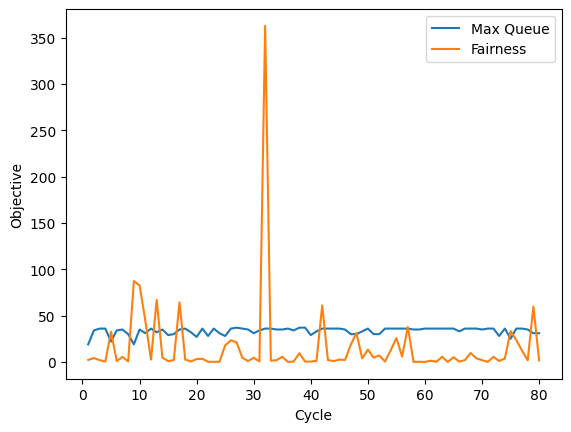

In [ ]:
# def visualize_results(path):
#     df = pd.read_csv(path)

#     plt.plot(df["cycle"], df["O1"], label="Max Queue")
#     plt.plot(df["cycle"], df["O2"], label="Fairness")
#     plt.legend(); plt.xlabel("Cycle"); plt.ylabel("Objective"); plt.show()

# visualize_results(SEED_DE_RESULTS_CSV)